In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

In [2]:
WIDTH, HEIGHT = 28, 28
num_classes = 10
img_channel = 1
learning_rate = 1e-4
img_shape = (WIDTH, HEIGHT, img_channel)
noise_dim = 100

In [3]:
from tensorflow.keras import layers

In [4]:
encoder_inputs= layers.Input(shape=(1,))
noise_input = layers.Input(shape=(256,))
encoder_embedding = Embedding(10, 100, input_length=1)

encoder_embeddings = encoder_embedding(encoder_inputs)
encoder_lstm=LSTM(256, return_state=True, kernel_regularizer=l2(0.0000001), activity_regularizer=l2(0.0000001))
LSTM_outputs, _, _ = encoder_lstm(encoder_embeddings)

mul = layers.multiply([noise_input, LSTM_outputs])


linear = layers.Dense(7*7*256, use_bias=False)(mul)

batch_norm = layers.BatchNormalization()(linear)
activation = layers.LeakyReLU()(batch_norm)

reshape = layers.Reshape((7, 7, 256))(activation)

x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(reshape)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

In [5]:
generator = Model([encoder_inputs,noise_input], x)

In [6]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 365568      embedding[0][0]                  
______________________________________________________________________________________________

In [7]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 2]))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1))

img = layers.Input(shape=(img_shape))
label = layers.Input(shape=(1,))

embedding = layers.Embedding(10, 100, input_length = 1)(label)
LSTM = LSTM(256, return_state=True)
LSTM_outputs, _, _ = LSTM(embedding)
linear = layers.Dense(28*28)(LSTM_outputs)
label_embedding = layers.Flatten()(linear)
label_embedding = layers.Reshape(img_shape)(label_embedding)

concat = layers.Concatenate(axis=-1)([img, label_embedding])
prediction = model(concat)
discriminator =  Model([img, label], prediction)

In [8]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
from tensorflow.keras.utils import plot_model

In [11]:
plot_model(
    discriminator,
    to_file="model.png")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
def save_models(epochs):
    generator.save_weights(f'generator-epochs-{epochs}.h5')
    discriminator.save_weihts(f'discriminator-epochs-{epochs}.h5')


In [14]:
def check_cuda():
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        return False 
    return True


In [15]:
def save_models(epochs):
    generator.save_weights(f'generator-epochs-{epochs}.h5')
    discriminator.save_weights(f'discriminator-epochs-{epochs}.h5')


In [16]:
tf.function
def train_step(batch_size, image, captions):
    image, label = image, captions
    with tf.device('/device:GPU:0'): 
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
            noise = np.random.normal(0, 1, size=(batch_size, 256))

            generated_images = generator([label, noise], training=True)

            real_output = discriminator([image, label], training=True)

            fake_output = discriminator([generated_images, label], training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        # tf.print(f'Genrator loss: {gen_loss} Discriminator loss: {disc_loss}')
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


(60000, 28, 28)


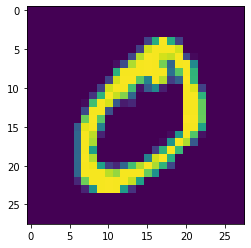

In [17]:

(X_train, y_train), (testX, testy) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32')

X_train = (X_train - 127.5) / 127.5

plt.imshow(X_train[1])
print(X_train.shape)

In [18]:
import time

def fit(epochs):
    batch_size=512
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        start = time.time()


        for i in range(len(X_train)//batch_size):
            image_batch = X_train[i*batch_size:(i+1)*batch_size]
            caption_batch = np.array(y_train[i*batch_size:(i+1)*batch_size])
            train_step(batch_size, image_batch, caption_batch)



In [ ]:
fit(1000)

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

KeyboardInterrupt: ignored

In [ ]:
save_models(100)

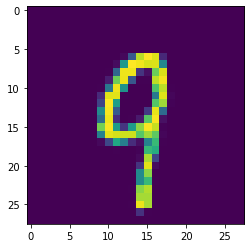

In [ ]:
plt.imshow(np.array(generator([np.expand_dims([[9]], axis=0), np.random.normal(0, 1)])).reshape(WIDTH,HEIGHT))

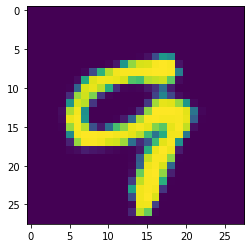

In [ ]:
img = np.array(generator([np.expand_dims([[9]], axis=0), np.random.normal(0, 1)])).reshape(WIDTH,HEIGHT)
plt.imshow(img.reshape(28, 28))       